In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # other options: tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

2024-12-09 23:59:40.236876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 23:59:40.257232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 23:59:40.263433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
project_dir = os.path.join(os.sep, 'projectnb', 'cs640grp', 'materials', 'ISIC-2024_CS640')
os.listdir(project_dir)

['test_metadata.csv',
 'submission.csv',
 'train_metadata.csv',
 'train_image',
 'test_image']

In [3]:
df = pd.read_csv(os.path.join(project_dir, "train_metadata.csv"))
df

,id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,0,55.0,male,upper extremity,2.58,3D: white,21.989610,18.149720,26.138980,...,3.207238,7.162229,1.181736,2.552678,2.169827,0.230000,45,-439.338600,1230.412000,22.647890
1,1,0,50.0,female,posterior torso,2.90,3D: XP,21.153528,17.243578,28.471102,...,2.749542,7.242474,1.014255,2.979940,1.937938,0.292453,65,-59.504822,1047.626465,109.244873
2,2,0,40.0,female,lower extremity,4.38,3D: XP,20.569130,14.896040,24.978840,...,4.339059,14.451710,1.233737,5.317332,1.839798,0.158025,0,-223.811100,770.993000,29.067170
3,3,0,50.0,female,upper extremity,2.76,3D: white,23.365559,18.483379,30.853418,...,1.650849,7.870664,0.496438,2.770145,2.381648,0.254237,90,-440.008942,1140.614502,-14.935974
4,4,0,60.0,male,posterior torso,3.31,3D: XP,23.061540,18.730060,29.790280,...,4.174303,10.950840,1.521283,1.608716,1.997881,0.461111,0,-108.822000,1215.113000,-101.404500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320842,320842,0,70.0,NaN,posterior torso,3.60,3D: XP,19.985520,15.393206,35.482277,...,1.317773,9.854949,0.359343,1.018512,2.205429,0.307692,115,30.655060,1204.034302,165.979797
320843,320843,0,45.0,male,posterior torso,5.88,3D: white,17.846150,11.566220,24.022090,...,6.996178,16.388990,1.827318,8.247600,2.282445,0.208081,140,-109.284200,1228.212000,155.480600
320844,320844,0,40.0,male,anterior torso,11.41,3D: XP,16.364410,6.870663,20.882192,...,3.671125,28.208751,1.136926,3.310037,1.509960,0.181329,0,-170.062561,1129.213257,28.841248
320845,320845,0,40.0,male,lower extremity,4.02,3D: XP,13.500010,10.076300,23.654770,...,2.443795,11.177810,0.847317,2.623507,3.329334,0.401914,10,249.819500,254.294600,55.758790


In [4]:
df_test = pd.read_csv(os.path.join(project_dir, "test_metadata.csv"))
df_test

,id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,0,NaN,30.0,male,upper extremity,2.52,3D: white,20.739760,17.346250,23.604410,...,2.013941,9.113276,0.793600,1.368380,3.130576,0.392593,85,-352.631000,1024.501000,21.431270
1,1,NaN,75.0,male,upper extremity,2.63,3D: white,21.498600,17.128050,26.919320,...,3.554856,6.968501,1.322546,2.980941,2.610491,0.342857,150,317.008100,1296.112000,85.410520
2,2,NaN,30.0,male,lower extremity,18.31,3D: XP,21.261867,15.949655,36.927874,...,3.685572,67.921989,1.323685,1.912243,3.394053,0.385400,145,-185.792664,680.623718,-21.791901
3,3,NaN,45.0,female,upper extremity,3.55,3D: XP,21.087236,15.657230,31.419333,...,2.082827,10.582854,0.691356,1.349557,1.570233,0.250000,155,443.583984,1213.412598,39.409851
4,4,NaN,55.0,male,anterior torso,7.06,3D: white,22.121790,14.444030,30.308130,...,3.691011,19.856620,0.989644,3.126280,2.467318,0.227068,70,-162.127900,1043.082000,-44.661830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80207,80207,NaN,75.0,male,posterior torso,2.88,3D: white,20.565030,15.228920,30.234170,...,1.458585,8.111398,0.618510,2.274461,1.914292,0.232000,10,-72.637900,1487.536000,138.852900
80208,80208,NaN,50.0,male,upper extremity,4.20,3D: white,16.314590,14.611030,25.403000,...,1.941789,11.952720,0.599103,1.422653,2.196585,0.331522,45,-477.687100,1121.040000,-38.915830
80209,80209,NaN,40.0,female,upper extremity,2.90,3D: XP,21.597580,17.705739,27.266721,...,3.355798,8.872541,1.076741,3.248064,1.624508,0.359477,25,442.464355,1128.834351,31.510681
80210,80210,NaN,75.0,male,posterior torso,3.32,3D: white,22.596327,20.186998,30.480790,...,0.000000,9.033031,0.000000,1.321416,2.082772,0.495050,10,-110.265747,1429.494385,156.874146


In [5]:
df_submission = pd.read_csv(os.path.join(project_dir, "submission.csv"))
df_submission

,id,target
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN
...,...,...
80207,80207,NaN
80208,80208,NaN
80209,80209,NaN
80210,80210,NaN


In [6]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    neg_sample = 0.01 # Downsample negative calss
    pos_sample = 5.0  # Upsample positive class
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [128, 128]  # Input image size
    epochs = 8 # Training epochs
    batch_size = 256  # Batch size
    lr_mode = "cos" # LR scheduler mode from one of "cos", "step", "exp"
    class_names = ['target']
    num_classes = 1

In [7]:
keras.utils.set_random_seed(CFG.seed)

In [8]:
keras.utils.set_random_seed(CFG.seed)

In [9]:
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

# Sampling
positive_df = df.query("target==0").sample(frac=CFG.neg_sample, random_state=CFG.seed)
negative_df = df.query("target==1").sample(frac=CFG.pos_sample, replace=True, random_state=CFG.seed)
df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0)

print("\nCalss Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

Class Distribution Before Sampling (%):


target
0    99.902134
1     0.097866
Name: proportion, dtype: float64


Calss Distribution After Sampling (%):


target
0    67.120419
1    32.879581
Name: proportion, dtype: float64

In [10]:
id_col = 'id'
target_col = 'target'

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]


new_num_cols = [
    'lesion_size_ratio',             # tbp_lv_minorAxisMM      / clin_size_long_diam_mm
    'lesion_shape_index',            # tbp_lv_areaMM2          / tbp_lv_perimeterMM **2
    'hue_contrast',                  # tbp_lv_H                - tbp_lv_Hext              abs
    'luminance_contrast',            # tbp_lv_L                - tbp_lv_Lext              abs
    'lesion_color_difference',       # tbp_lv_deltaA **2       + tbp_lv_deltaB **2 + tbp_lv_deltaL **2  sqrt  
    'border_complexity',             # tbp_lv_norm_border      + tbp_lv_symm_2axis
    'color_uniformity',              # tbp_lv_color_std_mean   / tbp_lv_radial_color_std_max

    'position_distance_3d',          # tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2  sqrt
    'perimeter_to_area_ratio',       # tbp_lv_perimeterMM      / tbp_lv_areaMM2
    'area_to_perimeter_ratio',       # tbp_lv_areaMM2          / tbp_lv_perimeterMM
    'lesion_visibility_score',       # tbp_lv_deltaLBnorm      + tbp_lv_norm_color
    'symmetry_border_consistency',   # tbp_lv_symm_2axis       * tbp_lv_norm_border
    'consistency_symmetry_border',   # tbp_lv_symm_2axis       * tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)

    'color_consistency',             # tbp_lv_stdL             / tbp_lv_Lext
    'consistency_color',             # tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
    'size_age_interaction',          # clin_size_long_diam_mm  * age_approx
    'hue_color_std_interaction',     # tbp_lv_H                * tbp_lv_color_std_mean
    'lesion_severity_index',         # tbp_lv_norm_border      + tbp_lv_norm_color + tbp_lv_eccentricity / 3
    'shape_complexity_index',        # border_complexity       + lesion_shape_index
    'color_contrast_index',          # tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm

    'log_lesion_area',               # tbp_lv_areaMM2          + 1  np.log
    'normalized_lesion_size',        # clin_size_long_diam_mm  / age_approx
    'mean_hue_difference',           # tbp_lv_H                + tbp_lv_Hext    / 2
    'std_dev_contrast',              # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2   / 3  np.sqrt
    'color_shape_composite_index',   # tbp_lv_color_std_mean   + bp_lv_area_perim_ratio + tbp_lv_symm_2axis   / 3
    'lesion_orientation_3d',         # tbp_lv_y                , tbp_lv_x  np.arctan2
    'overall_color_difference',      # tbp_lv_deltaA           + tbp_lv_deltaB + tbp_lv_deltaL   / 3

    'symmetry_perimeter_interaction',# tbp_lv_symm_2axis       * tbp_lv_perimeterMM
    'comprehensive_lesion_index',    # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis   / 4
    'color_variance_ratio',          # tbp_lv_color_std_mean   / tbp_lv_stdLExt
    'border_color_interaction',      # tbp_lv_norm_border      * tbp_lv_norm_color
    'size_color_contrast_ratio',     # clin_size_long_diam_mm  / tbp_lv_deltaLBnorm
    'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence  / age_approx
    'color_asymmetry_index',         # tbp_lv_symm_2axis       * tbp_lv_radial_color_std_max

    'volume_approximation_3d',       # tbp_lv_areaMM2          * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
    'color_range',                   # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
    'shape_color_consistency',       # tbp_lv_eccentricity     * tbp_lv_color_std_mean
    'border_length_ratio',           # tbp_lv_perimeterMM      / pi * sqrt(tbp_lv_areaMM2 / pi)
    'age_size_symmetry_index',       # age_approx              * clin_size_long_diam_mm * tbp_lv_symm_2axis
    'index_age_size_symmetry',       # age_approx              * tbp_lv_areaMM2 * tbp_lv_symm_2axis
]

def process_data(df, id_col, target_col, num_cols, new_num_cols, cat_cols, img_dir):
    """
    Processes the input DataFrame by creating additional features, normalizing numerical columns,
    and handling categorical features.

    Parameters:
    - df (pd.DataFrame): Input DataFrame to process.
    - id_col (str): Column name for unique IDs.
    - target_col (str): Column name for the target variable.
    - num_cols (list): List of numerical columns for direct use.
    - new_num_cols (list): List of new numerical features to compute.
    - cat_cols (list): List of categorical columns.

    Returns:
    - pd.DataFrame: Processed DataFrame with engineered features.
    """

    df['age_approx'] = df['age_approx'].fillna(df['age_approx'].median())

    df['sex'] = df['sex'].fillna('missing')

    df['anatom_site_general'] = df['anatom_site_general'].fillna('unknown')

    image_dir = os.path.join(project_dir, img_dir)   
    df['filepath'] = df['id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg")) 
    df = df[df['filepath'].apply(os.path.exists)]
    
    # --- Feature Engineering ---
    df['lesion_size_ratio'] = df['tbp_lv_minorAxisMM'] / df['clin_size_long_diam_mm']
    df['lesion_shape_index'] = df['tbp_lv_areaMM2'] / (df['tbp_lv_perimeterMM'] ** 2)
    df['hue_contrast'] = abs(df['tbp_lv_H'] - df['tbp_lv_Hext'])
    df['luminance_contrast'] = abs(df['tbp_lv_L'] - df['tbp_lv_Lext'])
    df['lesion_color_difference'] = np.sqrt(df['tbp_lv_deltaA'] ** 2 + df['tbp_lv_deltaB'] ** 2 + df['tbp_lv_deltaL'] ** 2)
    df['border_complexity'] = df['tbp_lv_norm_border'] + df['tbp_lv_symm_2axis']
    df['color_uniformity'] = df['tbp_lv_color_std_mean'] / df['tbp_lv_radial_color_std_max']
    df['position_distance_3d'] = np.sqrt(df['tbp_lv_x'] ** 2 + df['tbp_lv_y'] ** 2 + df['tbp_lv_z'] ** 2)
    df['perimeter_to_area_ratio'] = df['tbp_lv_perimeterMM'] / df['tbp_lv_areaMM2']
    df['area_to_perimeter_ratio'] = df['tbp_lv_areaMM2'] / df['tbp_lv_perimeterMM']
    df['lesion_visibility_score'] = df['tbp_lv_deltaLBnorm'] + df['tbp_lv_norm_color']
    df['symmetry_border_consistency'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border']
    df['consistency_symmetry_border'] = (df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border']) / (df['tbp_lv_symm_2axis'] + df['tbp_lv_norm_border'])
    df['color_consistency'] = df['tbp_lv_stdL'] / df['tbp_lv_Lext']
    df['consistency_color'] = (df['tbp_lv_stdL'] * df['tbp_lv_Lext']) / (df['tbp_lv_stdL'] + df['tbp_lv_Lext'])
    df['size_age_interaction'] = df['clin_size_long_diam_mm'] * df['age_approx']
    df['hue_color_std_interaction'] = df['tbp_lv_H'] * df['tbp_lv_color_std_mean']
    df['lesion_severity_index'] = (df['tbp_lv_norm_border'] + df['tbp_lv_norm_color'] + df['tbp_lv_eccentricity']) / 3
    df['shape_complexity_index'] = df['border_complexity'] + df['lesion_shape_index']
    df['color_contrast_index'] = df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL'] + df['tbp_lv_deltaLBnorm']
    df['log_lesion_area'] = np.log(df['tbp_lv_areaMM2'] + 1)
    df['normalized_lesion_size'] = df['clin_size_long_diam_mm'] / df['age_approx']
    df['mean_hue_difference'] = (df['tbp_lv_H'] + df['tbp_lv_Hext']) / 2
    df['std_dev_contrast'] = np.sqrt((df['tbp_lv_deltaA'] ** 2 + df['tbp_lv_deltaB'] ** 2 + df['tbp_lv_deltaL'] ** 2) / 3)
    df['color_shape_composite_index'] = (df['tbp_lv_color_std_mean'] + df['tbp_lv_area_perim_ratio'] + df['tbp_lv_symm_2axis']) / 3
    df['lesion_orientation_3d'] = np.arctan2(df['tbp_lv_y'], df['tbp_lv_x'])
    df['overall_color_difference'] = (df['tbp_lv_deltaA'] + df['tbp_lv_deltaB'] + df['tbp_lv_deltaL']) / 3
    df['symmetry_perimeter_interaction'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_perimeterMM']
    df['comprehensive_lesion_index'] = (df['tbp_lv_area_perim_ratio'] + df['tbp_lv_eccentricity'] + df['tbp_lv_norm_color'] + df['tbp_lv_symm_2axis']) / 4
    df['color_variance_ratio'] = df['tbp_lv_color_std_mean'] / df['tbp_lv_stdLExt']
    df['border_color_interaction'] = df['tbp_lv_norm_border'] * df['tbp_lv_norm_color']
    df['size_color_contrast_ratio'] = df['clin_size_long_diam_mm'] / df['tbp_lv_deltaLBnorm']
    df['age_normalized_nevi_confidence'] = df['tbp_lv_nevi_confidence'] / df['age_approx']
    df['color_asymmetry_index'] = df['tbp_lv_symm_2axis'] * df['tbp_lv_radial_color_std_max']
    df['volume_approximation_3d'] = df['tbp_lv_areaMM2'] * np.sqrt(df['tbp_lv_x'] ** 2 + df['tbp_lv_y'] ** 2 + df['tbp_lv_z'] ** 2)
    df['color_range'] = abs(df['tbp_lv_L'] - df['tbp_lv_Lext']) + abs(df['tbp_lv_A'] - df['tbp_lv_Aext']) + abs(df['tbp_lv_B'] - df['tbp_lv_Bext'])
    df['shape_color_consistency'] = df['tbp_lv_eccentricity'] * df['tbp_lv_color_std_mean']
    df['border_length_ratio'] = df['tbp_lv_perimeterMM'] / (np.pi * np.sqrt(df['tbp_lv_areaMM2'] / np.pi))
    df['age_size_symmetry_index'] = df['age_approx'] * df['clin_size_long_diam_mm'] * df['tbp_lv_symm_2axis']
    df['index_age_size_symmetry'] = df['age_approx'] * df['tbp_lv_areaMM2'] * df['tbp_lv_symm_2axis']

    # --- Normalize Numerical Features ---
    norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
    for col in num_cols + new_num_cols:
        df[f'{col}_patient_norm'] = df[col] / (np.log1p(df[col]))

    # --- Handle Categorical Features ---
    for col in cat_cols:
        df[col] = df[col].astype('category')  # Convert to categorical dtype

    # --- Return Processed Data ---
    return df

cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple']
norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient', "tbp_lv_areaMM2_patient", "tbp_lv_areaMM2_bp"] #'count_per_patient_bp'
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols

training_df = process_data(df, id_col='id', target_col='target', 
                                       num_cols=num_cols, new_num_cols=new_num_cols, cat_cols=cat_cols, img_dir='train_image')

testing_df = process_data(df_test, id_col='id', target_col='target', 
                                      num_cols=num_cols, new_num_cols=new_num_cols, cat_cols=cat_cols, img_dir='test_image')

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWa

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Assume df is your DataFrame and 'target' is the column with class labels
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7449297971918877, 1: 1.5207006369426752}


# Prepare for Tabular Model #

In [12]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Initialize Stratified K-Fold
n_splits = 5
sgkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for col in cat_cols:
    training_df[col] = df[col].astype('category')
    
# Prepare data
X = training_df.drop(columns=['target', 'id', 'filepath'])
y = training_df['target']



# Store results
fold_accuracies = []
folds_info = []

# Perform Stratified K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y)):
    
    folds_info.append((train_idx, val_idx))
    print(f"Training on Fold {fold + 1}...")
    
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Define LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)
    
    # Define parameters
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'seed': 42
    }
    
    # Train model
    lgb_model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],  # Validation data for early stopping
        callbacks=[
        lgb.early_stopping(stopping_rounds=3),
    ]
    )
    
    # Predict on validation set
    y_pred = (lgb_model.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold + 1} Accuracy: {accuracy}")

# Calculate overall cross-validation accuracy
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nOverall Cross-Validation Accuracy: {mean_accuracy}")


Training on Fold 1...
[LightGBM] [Info] Number of positive: 1256, number of negative: 2564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36602
[LightGBM] [Info] Number of data points in the train set: 3820, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328796 -> initscore=-0.713636
[LightGBM] [Info] Start training from score -0.713636
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0711171
Fold 1 Accuracy: 0.9801047120418848
Training on Fold 2...
[LightGBM] [Info] Number of positive: 1256, number of negative: 2564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36600
[LightGBM] 

In [13]:
from catboost import CatBoostClassifier, Pool

# Store fold results
fold_accuracies = []

# Perform Stratified K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y)):
    print(f"Training on Fold {fold + 1}...")
    
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Create CatBoost Pool objects for training and validation
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    val_pool = Pool(data=X_val, label=y_val, cat_features=cat_cols)
    
    # Define CatBoost parameters
    cat_model = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        eval_metric='Accuracy',
        random_seed=42,
        od_type='Iter',               # Enable early stopping
        od_wait=10,                   # Stop training after 10 rounds of no improvement
        verbose=100
    )
    
    # Train the model
    cat_model.fit(train_pool, eval_set=val_pool, use_best_model=True)
    
    # Predict on validation set
    y_pred = cat_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold + 1} Accuracy: {accuracy}")

# Calculate overall cross-validation accuracy
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nOverall Cross-Validation Accuracy: {mean_accuracy}")

Training on Fold 1...
0:	learn: 0.8767016	test: 0.8659686	best: 0.8659686 (0)	total: 67.5ms	remaining: 1m 7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9434554974
bestIteration = 71

Shrink model to first 72 iterations.
Fold 1 Accuracy: 0.9434554973821989
Training on Fold 2...
0:	learn: 0.8612565	test: 0.8691099	best: 0.8691099 (0)	total: 24.9ms	remaining: 24.9s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9120418848
bestIteration = 15

Shrink model to first 16 iterations.
Fold 2 Accuracy: 0.912041884816754
Training on Fold 3...
0:	learn: 0.8845550	test: 0.8575916	best: 0.8575916 (0)	total: 12.7ms	remaining: 12.7s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8942408377
bestIteration = 12

Shrink model to first 13 iterations.
Fold 3 Accuracy: 0.8942408376963351
Training on Fold 4...
0:	learn: 0.8568063	test: 0.8596859	best: 0.8596859 (0)	total: 11ms	remaining: 11s
Stopped by overfitting detector  (10 iterations wait)

In [14]:
train_idx, val_idx = folds_info[4]

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
# Define LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'seed': 42
}

# Train on all training data
final_model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],  # Validation data for early stopping
        callbacks=[
        lgb.early_stopping(stopping_rounds=3)
        ]
    )

[LightGBM] [Info] Number of positive: 1256, number of negative: 2564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36600
[LightGBM] [Info] Number of data points in the train set: 3820, number of used features: 152
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328796 -> initscore=-0.713636
[LightGBM] [Info] Start training from score -0.713636
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0744113


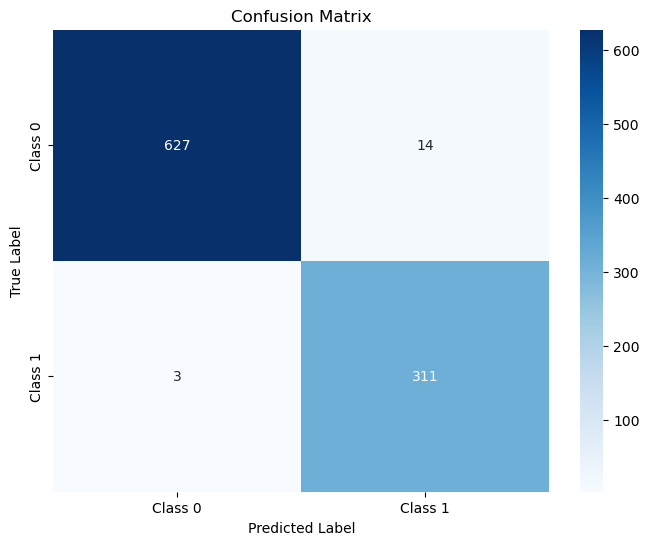

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, (final_model.predict(X_val) > 0.5).astype(int))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [17]:
X_test = testing_df.drop(columns=['id', 'target', 'filepath'])

test_preds = final_model.predict(X_test)
test_binary_preds = (test_preds > 0.5).astype(int)

In [18]:
df_submission['target'] = test_binary_preds
df_submission.to_csv('tab_submission.csv')

                                   Feature  Importance_Split  Importance_Gain
11                                tbp_lv_H               146     12896.665652
103         tbp_lv_norm_color_patient_norm                41      2893.253141
3                   clin_size_long_diam_mm               157      2653.951037
143  border_color_interaction_patient_norm                36      2469.850760
26                      tbp_lv_minorAxisMM                82      1636.090074
37                                tbp_lv_y                65      1582.909211
23                     tbp_lv_eccentricity                66      1086.645338
41                            hue_contrast               117       999.296411
47                 perimeter_to_area_ratio                34       995.054346
15                          tbp_lv_areaMM2                36       927.851725


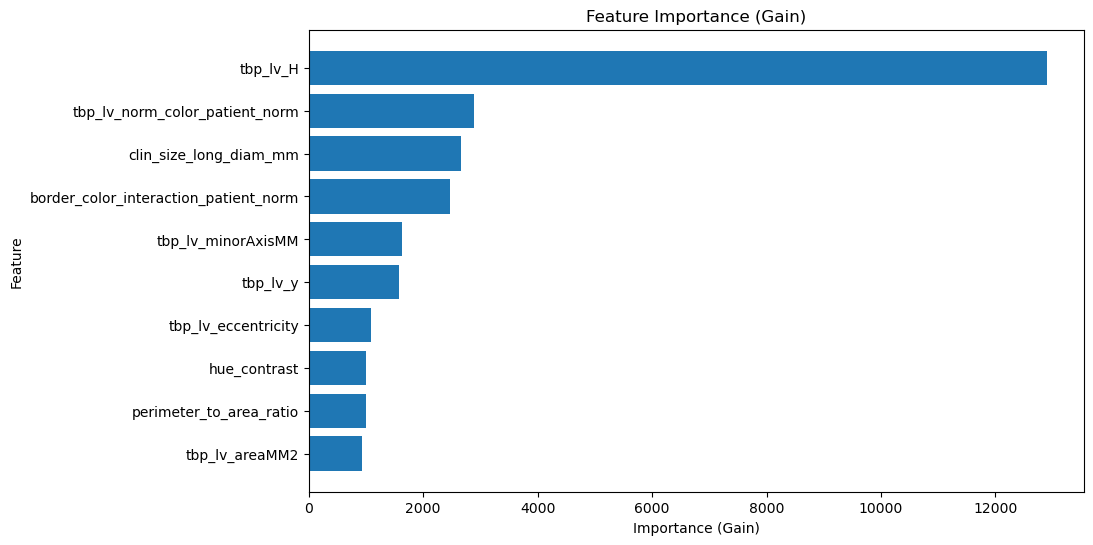

In [20]:
feature_names = training_df.drop(columns=['target', 'id', 'filepath']).columns

importance_split = final_model.feature_importance(importance_type='split')
importance_gain = final_model.feature_importance(importance_type='gain')

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Split': importance_split,
    'Importance_Gain': importance_gain
}).sort_values(by='Importance_Gain', ascending=False).head(10)

# Display feature importance
print(feature_importance_df)

# Plot feature importance (Gain)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance_Gain'])
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Feature Importance (Gain)')
plt.gca().invert_yaxis()  # Flip y-axis for better readability
plt.show()

# Prepare for CV model #

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, roc_auc_score

In [115]:
# Configurations
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    neg_sample = 0.01  # Downsample negative class
    pos_sample = 5.0  # Upsample positive class
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [128, 128]  # Input image size
    epochs = 8  # Training epochs
    batch_size = 32  # Batch size
    lr_mode = "cos"  # LR scheduler mode
    class_names = ['target']
    num_classes = 1

# Assuming `df` contains 'filename' (paths to images) and 'target' (labels)

# Compute class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df['target']),
    y=df['target']
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# Define the EfficientNetV2-B2 Transfer Learning Model
def create_efficientnet_model():
    # Load EfficientNetV2-B2 with pre-trained weights
    base_model = EfficientNetV2B2(
        weights='imagenet',  # Load pre-trained weights
        include_top=False,   # Exclude the top layer
        input_shape=(CFG.image_size[0], CFG.image_size[1], 3)
    )
    
    # Freeze the base model layers
    base_model.trainable = False
    """
    for layer in base_model.layers:
        if "top" in layer.name:
            layer.trainable = True
        else:
            layer.trainable = False
    """
    
    
    # Add custom layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    output = Dense(CFG.num_classes, activation='sigmoid')(x)  # For binary classification
    
    # Define the model
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Learning rate scheduler
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback
        
lr_cb = get_lr_callback(CFG.batch_size, mode="cos", plot=False)

X = training_df['filepath']
y = training_df['target']



fold_accuracies = []
fold_auc_scores = []
fold_models = []
fold_info = []

for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y)):
    print(f"Training on Fold {fold + 1}...")
    
    # Split the data
    train_files, val_files = X.iloc[train_idx], X.iloc[val_idx]
    train_labels, val_labels = y.iloc[train_idx], y.iloc[val_idx]

    train_labels = train_labels.astype(str)
    val_labels = val_labels.astype(str)
    
    # Create data generators
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    
    train_generator = train_datagen.flow_from_dataframe(
        pd.DataFrame({'filepath': train_files, 'target': train_labels}),
        x_col='filepath',
        y_col='target',
        target_size=(CFG.image_size[0], CFG.image_size[1]),
        batch_size=CFG.batch_size,
        class_mode='binary'
    )
    
    val_generator = val_datagen.flow_from_dataframe(
        pd.DataFrame({'filepath': val_files, 'target': val_labels}),
        x_col='filepath',
        y_col='target',
        target_size=(CFG.image_size[0], CFG.image_size[1]),
        batch_size=CFG.batch_size,
        class_mode='binary'
    )
    
    # Create a new model for this fold
    model = create_efficientnet_model()
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        metrics=[keras.metrics.AUC()]
    )

    ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_auc",    # Metric to monitor (validation AUC in this case).
    save_best_only=False,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)


    # Train the model
    history = model.fit(
        train_generator,
        epochs=CFG.epochs,
        validation_data=val_generator,
        class_weight=class_weights,  # Apply class weights
        callbacks=[lr_cb, ckpt_cb],
        verbose=CFG.verbose
    )

    # Evaluate on the validation set
    val_preds = model.predict(val_generator)  # Predictions are probabilities
    val_binary_preds = (val_preds > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

    # Ensure ground truth labels are integers
    val_labels = val_labels.astype(int)

    # Calculate metrics
    val_accuracy = accuracy_score(val_labels, val_binary_preds)
    val_auc = roc_auc_score(val_labels, val_preds.flatten())

    print(f"Fold {fold + 1} Validation Accuracy: {val_accuracy}")
    print(f"Fold {fold + 1} Validation AUC: {val_auc}")
    
    # Save results
    fold_accuracies.append(val_accuracy)
    fold_auc_scores.append(val_auc)
    fold_models.append(model)
    fold_info.append((train_idx, val_idx))

# Print cross-validation results
print(f"\nMean Cross-Validation Accuracy: {np.mean(fold_accuracies)}")
print(f"Mean Cross-Validation AUC: {np.mean(fold_auc_scores)}")

# Optionally save models or make predictions with ensemble


Class Weights: {0: 0.7449297971918877, 1: 1.5207006369426752}
Training on Fold 1...
Found 3820 validated image filenames belonging to 2 classes.
Found 955 validated image filenames belonging to 2 classes.
Epoch 1/8


/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 57s 274ms/step - auc_76: 0.4953 - loss: 0.6939 - val_auc_76: 0.5038 - val_loss: 0.6924 - learning_rate: 2.5000e-05
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - auc_76: 0.4859 - loss: 0.6949 - val_auc_76: 0.5362 - val_loss: 0.6913 - learning_rate: 7.0000e-05
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - auc_76: 0.5059 - loss: 0.6902 - val_auc_76: 0.4999 - val_loss: 0.6967 - learning_rate: 1.1500e-04
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - auc_76: 0.5123 - loss: 0.6955 - val_auc_76: 0.5342 - val_loss: 0.7054 - learning_rate: 1.6000e-04
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - auc_76: 0.5169 - loss: 0.6882 - val_auc_76: 0.4918 - val_loss: 0.7096 - learning_rate: 1.5628e-04
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - auc_76: 0.4968 - loss: 0.6966 - val_auc_76: 0.5479 - val_loss: 0.6947 - learning_rate: 1.4549e-04
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - auc_76: 0.5113 - loss: 0.6916 

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 55s 267ms/step - auc_77: 0.4987 - loss: 0.7075 - val_auc_77: 0.5000 - val_loss: 0.6837 - learning_rate: 2.5000e-05
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_77: 0.4905 - loss: 0.6956 - val_auc_77: 0.5100 - val_loss: 0.7022 - learning_rate: 7.0000e-05
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_77: 0.4922 - loss: 0.6919 - val_auc_77: 0.5000 - val_loss: 0.6926 - learning_rate: 1.1500e-04
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_77: 0.4879 - loss: 0.6850 - val_auc_77: 0.5000 - val_loss: 0.7239 - learning_rate: 1.6000e-04
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - auc_77: 0.4767 - loss: 0.6954 - val_auc_77: 0.5000 - val_loss: 0.6895 - learning_rate: 1.5628e-04
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - auc_77: 0.5114 - loss: 0.6893 - val_auc_77: 0.5000 - val_loss: 0.6944 - learning_rate: 1.4549e-04
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - auc_77: 0.4991 - loss: 0.6902 

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 55s 265ms/step - auc_78: 0.4842 - loss: 0.6974 - val_auc_78: 0.4987 - val_loss: 0.6881 - learning_rate: 2.5000e-05
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - auc_78: 0.4866 - loss: 0.6989 - val_auc_78: 0.5000 - val_loss: 0.6927 - learning_rate: 7.0000e-05
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - auc_78: 0.4939 - loss: 0.6992 - val_auc_78: 0.5000 - val_loss: 0.6920 - learning_rate: 1.1500e-04
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_78: 0.5038 - loss: 0.6976 - val_auc_78: 0.4961 - val_loss: 0.6978 - learning_rate: 1.6000e-04
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - auc_78: 0.4933 - loss: 0.7014 - val_auc_78: 0.5000 - val_loss: 0.6900 - learning_rate: 1.5628e-04
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - auc_78: 0.5050 - loss: 0.7021 - val_auc_78: 0.5000 - val_loss: 0.6826 - learning_rate: 1.4549e-04
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_78: 0.4916 - loss: 0.6954 

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 56s 269ms/step - auc_79: 0.5093 - loss: 0.7029 - val_auc_79: 0.4953 - val_loss: 0.7037 - learning_rate: 2.5000e-05
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - auc_79: 0.5127 - loss: 0.6957 - val_auc_79: 0.4961 - val_loss: 0.6903 - learning_rate: 7.0000e-05
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - auc_79: 0.4917 - loss: 0.7003 - val_auc_79: 0.4984 - val_loss: 0.6859 - learning_rate: 1.1500e-04
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_79: 0.4748 - loss: 0.7059 - val_auc_79: 0.4977 - val_loss: 0.6895 - learning_rate: 1.6000e-04
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_79: 0.5065 - loss: 0.6899 - val_auc_79: 0.5084 - val_loss: 0.7051 - learning_rate: 1.5628e-04
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_79: 0.5165 - loss: 0.6961 - val_auc_79: 0.4961 - val_loss: 0.6810 - learning_rate: 1.4549e-04
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - auc_79: 0.4905 - loss: 0.6991 

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 56s 267ms/step - auc_80: 0.4894 - loss: 0.7073 - val_auc_80: 0.5000 - val_loss: 0.6930 - learning_rate: 2.5000e-05
Epoch 2/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - auc_80: 0.4872 - loss: 0.6934 - val_auc_80: 0.5327 - val_loss: 0.6982 - learning_rate: 7.0000e-05
Epoch 3/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - auc_80: 0.4844 - loss: 0.6984 - val_auc_80: 0.4994 - val_loss: 0.6913 - learning_rate: 1.1500e-04
Epoch 4/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - auc_80: 0.5115 - loss: 0.6892 - val_auc_80: 0.5000 - val_loss: 0.6940 - learning_rate: 1.6000e-04
Epoch 5/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - auc_80: 0.4857 - loss: 0.7012 - val_auc_80: 0.5000 - val_loss: 0.7005 - learning_rate: 1.5628e-04
Epoch 6/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - auc_80: 0.4701 - loss: 0.6993 - val_auc_80: 0.5092 - val_loss: 0.6950 - learning_rate: 1.4549e-04
Epoch 7/8
120/120 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - auc_80: 0.4822 - loss: 0.6994 

In [ ]:
from sklearn.metrics import confusion_matrix

train_idx, val_idx = fold_info[0]
model = fold_models[0]

train_files, val_files = X.iloc[train_idx], X.iloc[val_idx]
train_labels, val_labels = y.iloc[train_idx], y.iloc[val_idx]

train_labels = train_labels.astype(str)
val_labels = val_labels.astype(str)

val_generator = val_datagen.flow_from_dataframe(
        pd.DataFrame({'filepath': val_files, 'target': val_labels}),
        x_col='filepath',
        y_col='target',
        target_size=(CFG.image_size[0], CFG.image_size[1]),
        batch_size=CFG.batch_size,
        class_mode='binary'
    )

val_preds = model.predict(val_generator)
val_binary_preds = (val_preds > 0.5).astype(int).flatten()
val_labels = val_labels.astype(int)

cm = confusion_matrix(val_labels, val_binary_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

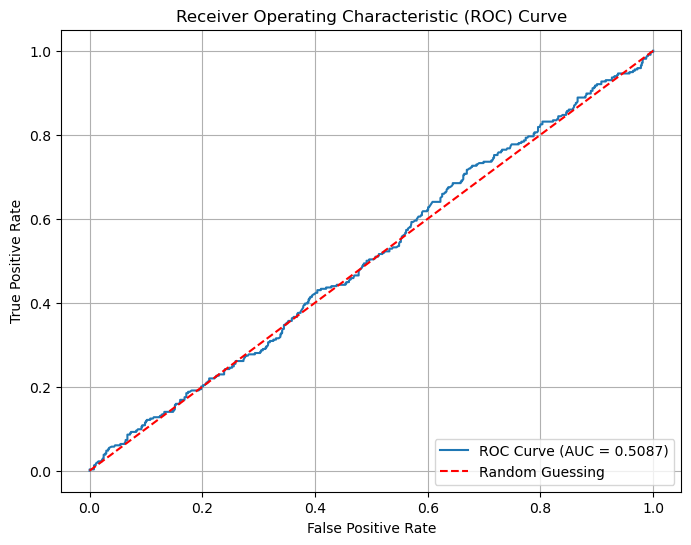

In [126]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Suppose val_labels are your ground truth labels and val_preds are your predicted probabilities
fpr, tpr, thresholds = roc_curve(val_labels, val_preds.flatten())

# Calculate the area under the curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# To inspect thresholds
# thresholds array has corresponding thresholds for each point on the curve
# fpr[i], tpr[i], thresholds[i] indicate that at thresholds[i], you get fpr[i] and tpr[i]


# Multimodal Fusion Model #

In [150]:
datagen = ImageDataGenerator(rescale=1.0 / 255)
data_generator = datagen.flow_from_dataframe(
        pd.DataFrame({'filepath': training_df['filepath'], 'target': training_df['target'].astype(str)}),
        x_col='filepath',
        y_col='target',
        target_size=(CFG.image_size[0], CFG.image_size[1]),
        batch_size=CFG.batch_size,
        class_mode='binary'
    )
model = fold_models[4]

CNN_preds = model.predict(data_generator)

Found 4775 validated image filenames belonging to 2 classes.
  7/150 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step


In [151]:
training_df['CNN pred'] = CNN_preds


n_splits = 5
sgkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for col in cat_cols:
    training_df[col] = df[col].astype('category')
    
# Prepare data
X = training_df.drop(columns=['target', 'id', 'filepath'])
y = training_df['target']

# Store results
fold_accuracies = []
folds_info = []

# Perform Stratified K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y)):
    
    folds_info.append((train_idx, val_idx))
    print(f"Training on Fold {fold + 1}...")
    
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Define LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)
    
    # Define parameters
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'seed': 42
    }
    
    # Train model
    lgb_model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],  # Validation data for early stopping
        callbacks=[
        lgb.early_stopping(stopping_rounds=3),
    ]
    )
    
    # Predict on validation set
    y_pred = (lgb_model.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)
    fold_accuracies.append(accuracy)
    print(f"Fold {fold + 1} Accuracy: {accuracy}")

# Calculate overall cross-validation accuracy
mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nOverall Cross-Validation Accuracy: {mean_accuracy}")

Training on Fold 1...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1256, number of negative: 2564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36857
[LightGBM] [Info] Number of data points in the train set: 3820, number of used features: 153
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328796 -> initscore=-0.713636
[LightGBM] [Info] Start training from score -0.713636
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0719001
Fold 1 Accuracy: 0.981151832460733
Training on Fold 2...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 

In [152]:
train_idx, val_idx = folds_info[4]

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
# Define LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'seed': 42
}

# Train on all training data
final_model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],  # Validation data for early stopping
        callbacks=[
        lgb.early_stopping(stopping_rounds=3)
        ]
    )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1256, number of negative: 2564
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 36855
[LightGBM] [Info] Number of data points in the train set: 3820, number of used features: 153
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.328796 -> initscore=-0.713636
[LightGBM] [Info] Start training from score -0.713636
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.0747359


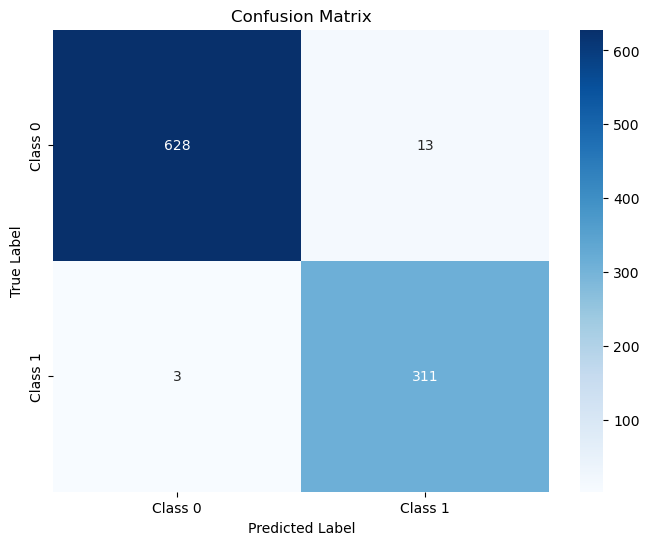

In [153]:
cm = confusion_matrix(y_val, (final_model.predict(X_val) > 0.5).astype(int))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [159]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_data_generator = test_datagen.flow_from_dataframe(
        pd.DataFrame({'filepath': testing_df['filepath']}),
        x_col='filepath',
        target_size=(CFG.image_size[0], CFG.image_size[1]),
        batch_size=CFG.batch_size,
        class_mode=None
    )
model = fold_models[4]

CNN_preds = model.predict(test_data_generator)

Found 80212 validated image filenames.


/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2507/2507 ━━━━━━━━━━━━━━━━━━━━ 131s 50ms/step


In [160]:
X_test = testing_df.drop(columns=['id', 'target', 'filepath'])
X_test['CNN preds'] = CNN_preds

test_preds = final_model.predict(X_test)
test_binary_preds = (test_preds > 0.5).astype(int)

/scratch/1467101.1.p100/ipykernel_4091507/2633526509.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test['CNN preds'] = CNN_preds


In [161]:
df_submission['target'] = test_binary_preds
df_submission.to_csv('tab_submission.csv')

                                   Feature  Importance_Split  Importance_Gain
11                                tbp_lv_H               138     12876.321702
103         tbp_lv_norm_color_patient_norm                42      2895.650251
3                   clin_size_long_diam_mm               156      2654.258168
143  border_color_interaction_patient_norm                36      2468.379780
26                      tbp_lv_minorAxisMM                80      1636.873874
37                                tbp_lv_y                71      1603.449281
23                     tbp_lv_eccentricity                63      1077.798788
41                            hue_contrast               121      1006.554450
47                 perimeter_to_area_ratio                36      1000.485606
15                          tbp_lv_areaMM2                36       929.750565


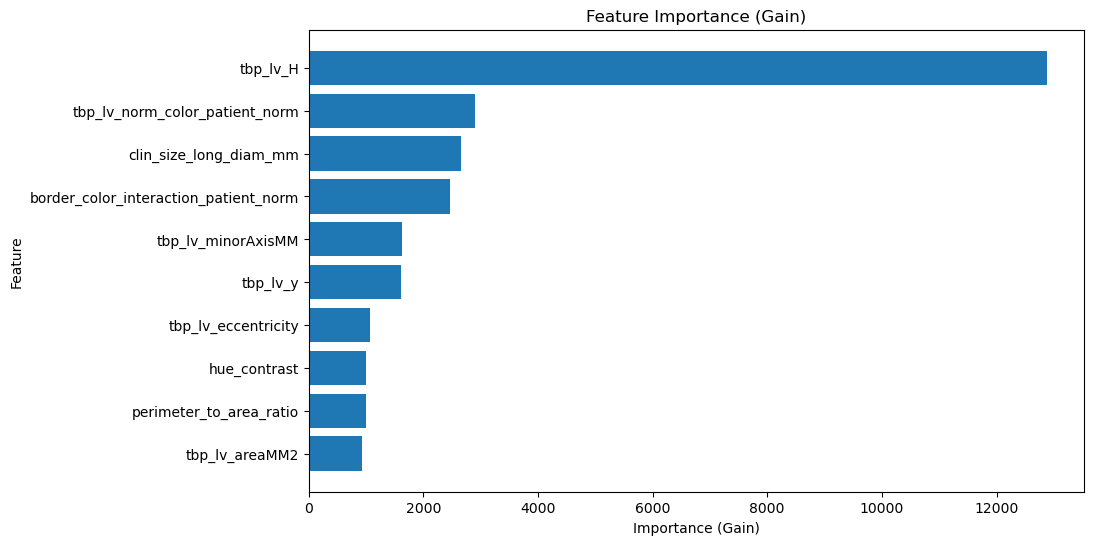

In [162]:
feature_names = training_df.drop(columns=['target', 'id', 'filepath']).columns

importance_split = final_model.feature_importance(importance_type='split')
importance_gain = final_model.feature_importance(importance_type='gain')

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Split': importance_split,
    'Importance_Gain': importance_gain
}).sort_values(by='Importance_Gain', ascending=False).head(10)

# Display feature importance
print(feature_importance_df)

# Plot feature importance (Gain)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance_Gain'])
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Feature Importance (Gain)')
plt.gca().invert_yaxis()  # Flip y-axis for better readability
plt.show()

In [163]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Split': importance_split,
    'Importance_Gain': importance_gain
}).sort_values(by='Importance_Gain', ascending=False)